In [1]:
from network import Genre_Model
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


In [2]:
def load_data():
    data_path = 'Data/images_original/'
    transform = transforms.Compose([transforms.ToTensor()])
    return datasets.ImageFolder(data_path, transform=transform)
#         blues = datasets.ImageFolder(data_path +'blues', transform=transform)
#         classical = datasets.ImageFolder(data_path + 'classical', transform=transform)
#         country = datasets.ImageFolder(data_path + 'country', transform=transform)
#         disco = datasets.ImageFolder(data_path + 'disco', transform=transform)
#         hiphop = datasets.ImageFolder(data_path + 'hiphop', transform=transform)
#         jazz = datasets.ImageFolder(data_path + 'jazz', transform=transform)
#         metal = datasets.ImageFolder(data_path + 'metal', transform=transform)
#         pop = datasets.ImageFolder(data_path + 'pop', transform=transform)
#         reggae = datasets.ImageFolder(data_path + 'reggae', transform=transform)
#         rock = datasets.ImageFolder(data_path + 'rock', transform=transform)
#         return torch.utils.data.ConcatDataset(
#             [blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock])


In [3]:
dataset = load_data()
split_percent = 0.2
length = len(dataset)
test_threshold = int(length * split_percent)

test, train = torch.utils.data.random_split(
    dataset, [test_threshold, length-test_threshold])

# test = torch.utils.data.Subset(dataset, range(test_threshold))
# train = torch.utils.data.Subset(dataset, range(test_threshold, length))


In [4]:
net = Genre_Model()


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
batch_size = 32
epochs = 20


In [6]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=True)


In [7]:
# images, labels = next(iter(train_loader))
# for img, label in zip(images, labels):
#     img = img.permute(1, 2, 0) # Have to arrange the channel dimension to be last to display
#     print(img.size())
#     plt.imshow(img)
#     plt.title(label)
#     plt.show()

In [16]:
%%time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

losses = []
mean_loss_per_epoch = []

for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Uses the GPU if available
        inputs = inputs.cuda()
        labels = labels.cuda()
#         print(labels)

        optimizer.zero_grad()

        outputs = net(inputs)  # Forward pass
#         print(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%20 == 19:
            print(f'[{epoch+1},{i+1:5d}] loss: {running_loss/20}')
            running_loss = 0.0
#         losses.append(loss.item())
        
#         print("Epoch", epoch + 1, "loss:", running_loss)
#     mean_loss = sum(losses) / len(losses)
#     mean_loss_per_epoch.append(mean_loss)


print('Finished Training')


[1,   20] loss: 2.201940417289734
[2,   20] loss: 2.199594700336456
[3,   20] loss: 2.2036529660224913
[4,   20] loss: 2.197204029560089
[5,   20] loss: 2.1978978157043456
[6,   20] loss: 2.1966622114181518
[7,   20] loss: 2.2006404399871826
[8,   20] loss: 2.187481951713562
[9,   20] loss: 2.18471155166626
[10,   20] loss: 2.1976393342018126
[11,   20] loss: 2.189295065402985
[12,   20] loss: 2.1707416772842407
[13,   20] loss: 2.1754480242729186
[14,   20] loss: 2.173742175102234
[15,   20] loss: 2.1574888110160826
[16,   20] loss: 2.1604071378707888
[17,   20] loss: 2.1577154994010925
[18,   20] loss: 2.145165228843689
[19,   20] loss: 2.1457064509391786
[20,   20] loss: 2.145378816127777
Finished Training
CPU times: user 10min 52s, sys: 31.2 s, total: 11min 23s
Wall time: 2min 14s


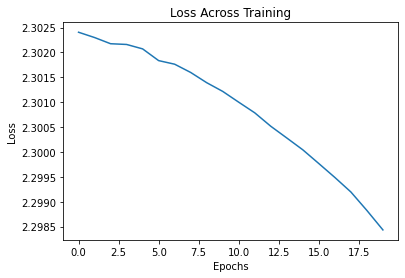

In [9]:
plt.plot(range(20), mean_loss_per_epoch)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Across Training")
plt.show()


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net.to(device)

correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(labels, predicted)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted)
        y_true.extend(labels)

print('Accuracy:', 100 * correct / total,  '%')


Accuracy: 25.628140703517587 %


In [18]:
y_pred2 = []
for i in y_pred:
    y_pred2.append(i.item())

y_true2 = []
for i in y_true:
    y_true2.append(i.item())


<AxesSubplot:>

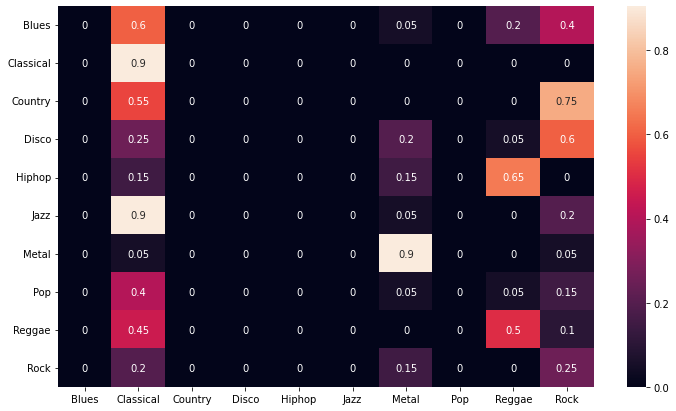

In [19]:
classes = ('Blues', 'Classical', 'Country', 'Disco', 'Hiphop',
           'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock')


cf_matrix = confusion_matrix(y_true2, y_pred2)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                     columns=[i for i in classes])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm, annot=True)
